In [ ]:
####10608912.txt

[(['Columbia', 'Magenta'], [('keep', 'action')]), (['Columbia', 'Magenta', 'Riff Raff'], [('say', 'conversations'), ('care', 'affection'), ('giving', 'action'), ('hit', 'mental_action')]), (['Frank N. Furter', 'Riff Raff'], [('plan', 'action')]), (['Frank N. Furter', 'Riff Raff'], [('cast', 'action')]), (['Magenta', 'Riff Raff'], [('bit', 'action')]), (['Magenta', 'Riff Raff'], [('play', 'action')]), (['Frank N. Furter', 'Riff Raff'], [('love', 'affection'), ('use', 'action')]), (['Frank N. Furter', 'Riff Raff'], [('trust', 'action')]), (['Frank N. Furter', 'Magenta'], [('say', 'conversations'), ('touch', 'action')]), (['Frank N. Furter', 'Magenta'], [('act', 'action'), ('miss', 'mental_action')]), (['Frank N. Furter', 'Magenta'], [('call', 'conversations'), ('burst', 'action'), ('think', 'mental_action')]), (['Frank N. Furter', 'Magenta'], [('say', 'conversations'), ('roll', 'action'), ('guess', 'mental_action')]), (['Frank N. Furter', 'Magenta'], [('say', 'conversations'), ('ask', 'a

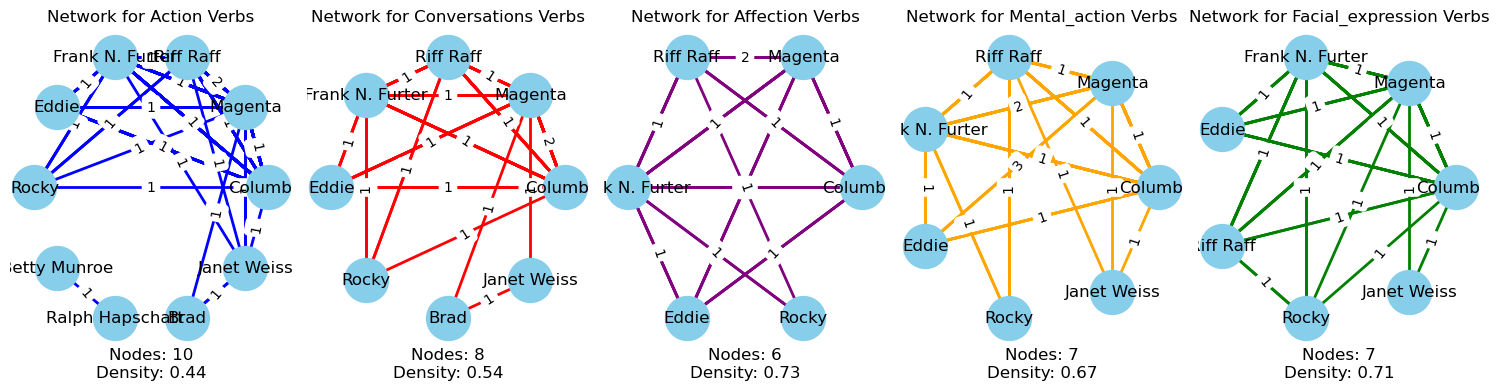

In [1]:
import json##It is used to read files in JSON format
import re ## Used for regular expression operations.
import networkx as nx ##For network analysis
import matplotlib.pyplot as plt ##Used to draw graphics.

##Read the list of verbs, load the verb data from the specified JSON file.
def load_action_verbs(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        action_verbs = json.load(file)
    return action_verbs

##Read the list of character variants
def load_character_variants(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        character_variants = json.load(file)
    return character_variants

##Read the text file
def read_text_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

##Extract related sentences, split the text by sentence punctuation, 
##and filter out sentences with two or more characters.
def extract_relevant_sentences(text, character_variants):
    sentences = re.split(r'(?<=[.!?]) +', text)
    relevant_sentences = []
    
    for sentence in sentences:
        characters = find_characters_in_text(sentence, character_variants)
        if len(characters) >= 2:
            relevant_sentences.append((sentence, characters))
    
    return relevant_sentences

##Extract roles and verbs from sentences.
def extract_characters_and_verbs(sentence, character_variants, action_verbs):
    characters = find_characters_in_text(sentence, character_variants)
    verbs = find_verbs_in_text(sentence, action_verbs)
    return characters, verbs

##Check if any of the variants of the role appear in the text and return the found role
def find_characters_in_text(text, character_variants):
    characters_in_text = []
    for character, variants in character_variants.items():
        for variant in variants:
            if variant in text:
                characters_in_text.append(character)
                break
    return characters_in_text

##Checks for verbs in the text and returns verbs and their types
def find_verbs_in_text(text, action_verbs):
    verbs_in_text = []
    for verb_type, verbs in action_verbs.items():
        for verb in verbs:
            if verb in text:
                verbs_in_text.append((verb, verb_type))
                break
    return verbs_in_text


text_file_path = '/Users/meinv/Documents/booknlp_for_Ao3/originalwork_txt/10608912.txt'


text = read_text_file(text_file_path)


action_verbs_file = 'verb_cater_1.json'


character_variants_file = 'character_variants_RHPS.json'


action_verbs = load_action_verbs(action_verbs_file)


character_variants = load_character_variants(character_variants_file)


relevant_sentences = extract_relevant_sentences(text, character_variants)

##Extract related sentences from the text and the roles and verbs they contain and store them in the form of role-verb pairs.
character_verb_pairs = []
for sentence, _ in relevant_sentences:
    characters, verbs = extract_characters_and_verbs(sentence, character_variants, action_verbs)
    if characters and verbs:
        character_verb_pairs.append((characters, verbs))

print(character_verb_pairs)

##Build polygon networks, model relationships between characters based on verb types, 
##and create a network for each verb type.
def build_multiedge_network(character_verb_pairs):
    networks = {}
    for characters, verbs in character_verb_pairs:
        for verb, verb_type in verbs:
            if verb_type not in networks:
                networks[verb_type] = nx.MultiGraph()
            network = networks[verb_type]
            for i, char1 in enumerate(characters):
                for char2 in characters[i + 1:]:
                    if network.has_edge(char1, char2, key=verb):
                        network[char1][char2][verb]['weight'] += 1
                    else:
                        network.add_edge(char1, char2, key=verb, weight=1, type=verb_type)
    return networks

##Calculate network density
def calculate_network_density(network):
    simple_network = nx.Graph(network)  
    density = nx.density(simple_network)
    return density

##Visualize polygon networks of different verb types, 
##use different colors to represent different types of verbs, 
##and show the number of nodes and network density in the graph.
def visualize_multiedge_networks(networks):
    colors = {
        'conversations': 'red',
        'action': 'blue',
        'mental_action': 'orange',
        'affection': 'purple',
        'facial_expression': 'green'
    }
    fig, axes = plt.subplots(nrows=1, ncols=len(networks), figsize=(15, 4))  # 创建多个子图

    for i, (verb_type, network) in enumerate(networks.items()):
        if network.number_of_edges() > 0:
            pos = nx.circular_layout(network)
            nx.draw(network, pos, with_labels=True, node_size=1000, node_color='skyblue', edge_color=colors[verb_type], width=2, ax=axes[i])
            
            
            edge_labels = {(u, v): d['weight'] for u, v, d in network.edges(data=True)}
            nx.draw_networkx_edge_labels(network, pos, edge_labels=edge_labels, font_color='black', ax=axes[i])

            
            node_count = network.number_of_nodes()
            network_density = calculate_network_density(network)
            axes[i].text(0.5, -0.1, f'Nodes: {node_count}\nDensity: {network_density:.2f}', size=12, ha='center', transform=axes[i].transAxes)
            
            axes[i].set_title(f'Network for {verb_type.capitalize()} Verbs')

    plt.tight_layout() 
    plt.show()

networks = build_multiedge_network(character_verb_pairs)


visualize_multiedge_networks(networks)
